In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [ ]:
tickers = ['MRF.BO', 'PAGEIND.BO', 'BOSCHLTD.BO', 'NTPC.BO', 'BEL.BO']
start_date = '2020-01-01'
end_date='END'
trading_days = 252

In [ ]:
data = yf.download(tickers, start=start_date, progress=False)['Close']
print(data.head())

/tmp/ipython-input-2015233259.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, progress=False)['Close']


Ticker         BEL.BO   BOSCHLTD.BO        MRF.BO    NTPC.BO    PAGEIND.BO
Date                                                                      
2020-01-01  25.508858  14316.602539  66011.335938  98.077988  22212.332031
2020-01-02  26.286098  14434.021484  66633.609375  97.956902  22191.962891
2020-01-03  25.738209  14207.760742  65921.414062  96.302101  21921.259766
2020-01-06  24.706133  13918.100586  64799.566406  95.979202  21510.242188
2020-01-07  24.553230  13880.852539  64723.144531  97.270775  21498.855469


In [ ]:
returns = data.pct_change().dropna()

/tmp/ipython-input-1517689983.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [ ]:
mean_returns = returns.mean() * trading_days
cov_matrix = returns.cov() * trading_days

In [ ]:
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [ ]:
n = len(tickers)
init_guess = [1/n] * n
bounds = [(0, 1)] * n
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

In [ ]:
result = minimize(portfolio_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
weights = result.x

In [ ]:
portfolio_return = np.dot(weights, mean_returns)
portfolio_vol = portfolio_volatility(weights)

In [ ]:
print("Minimum Variance Portfolio (Markowitz):")
print("Optimal Weights:")
for ticker, w in zip(tickers, weights):
    print(f"{ticker}: {w:.4f}")

Minimum Variance Portfolio (Markowitz):
Optimal Weights:
MRF.BO: 0.0130
PAGEIND.BO: 0.1271
BOSCHLTD.BO: 0.3288
NTPC.BO: 0.2546
BEL.BO: 0.2764


In [ ]:
print("\nPortfolio Performance:")
print(f"Expected Annual Return: {portfolio_return:.2%}")
print(f"Annual Volatility     : {portfolio_vol:.2%}")


Portfolio Performance:
Expected Annual Return: 20.67%
Annual Volatility     : 19.86%


# Now with Gradient Boosting

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
tickers = ['MRF.BO', 'ADANIPORTS.BO', 'BOSCHLTD.BO', 'NTPC.BO', 'BEL.BO']

data = yf.download(tickers, start="2020-01-01", end="2023-12-31")['Close']

returns = data.pct_change().dropna()
print(returns.head())

/tmp/ipython-input-2388498082.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2023-12-31")['Close']
[*********************100%***********************]  5 of 5 completed

Ticker      ADANIPORTS.BO    BEL.BO  BOSCHLTD.BO    MRF.BO   NTPC.BO
Date                                                                
2020-01-02       0.015358  0.030470     0.008202  0.009427 -0.001235
2020-01-03      -0.001956 -0.020843    -0.015676 -0.010688 -0.016893
2020-01-06      -0.006533 -0.040099    -0.020387 -0.017018 -0.003353
2020-01-07       0.011704 -0.006189    -0.002676 -0.001179  0.013457
2020-01-08       0.002600 -0.008822    -0.018515 -0.007254 -0.004564



/tmp/ipython-input-2388498082.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [ ]:
lagged_data = returns.copy()

for lag in range(1, 6):  # 5 lags
    for col in returns.columns:
        lagged_data[f'{col}_lag{lag}'] = returns[col].shift(lag)

lagged_data.dropna(inplace=True)

X = lagged_data.drop(columns=returns.columns)
predicted_returns = {}

In [ ]:
for stock in returns.columns:
    y = lagged_data[stock]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    predicted_returns[stock] = y_pred[-1]

    print(f"{stock}: MSE = {mse:.6f}")

ADANIPORTS.BO: MSE = 0.000598
BEL.BO: MSE = 0.000294
BOSCHLTD.BO: MSE = 0.000169
MRF.BO: MSE = 0.000138
NTPC.BO: MSE = 0.000216


In [ ]:
predicted_series = pd.Series(predicted_returns)

predicted_series = predicted_series.clip(lower=0)

if predicted_series.sum() == 0:
    weights = pd.Series([1/len(predicted_series)] * len(predicted_series), index=predicted_series.index)
else:
    weights = predicted_series / predicted_series.sum()

print("\nPredicted Returns:")
print(predicted_series)

print("\nPortfolio Weights (No Short Selling):")
print(weights)


Predicted Returns:
ADANIPORTS.BO    0.014991
BEL.BO           0.002403
BOSCHLTD.BO      0.002996
MRF.BO           0.000000
NTPC.BO          0.001922
dtype: float64

Portfolio Weights (No Short Selling):
ADANIPORTS.BO    0.671862
BEL.BO           0.107711
BOSCHLTD.BO      0.134290
MRF.BO           0.000000
NTPC.BO          0.086138
dtype: float64


In [ ]:
expected_return = (weights * predicted_series).sum()
print(f"\nExpected Portfolio Return (next day): {expected_return:.6f}")


Expected Portfolio Return (next day): 0.010899


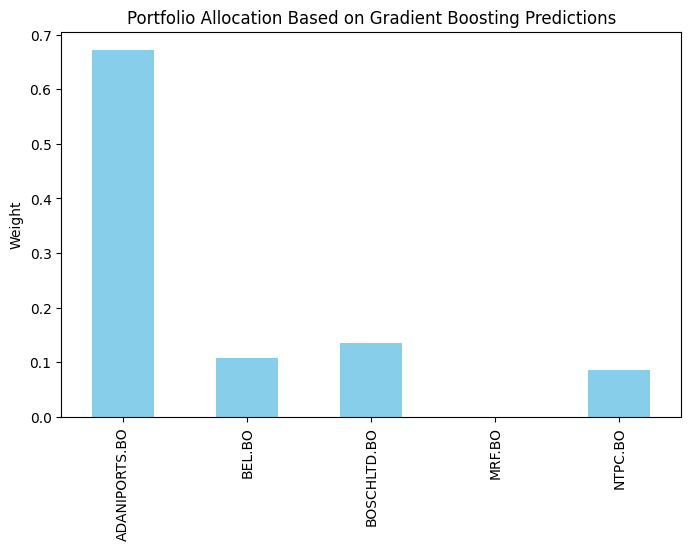

In [ ]:
plt.figure(figsize=(8, 5))
weights.plot(kind='bar', color='skyblue')
plt.title('Portfolio Allocation Based on Gradient Boosting Predictions')
plt.ylabel('Weight')
plt.show()